In [1]:
import numpy as np
import os, random

In [2]:
class Estimator():
    def __init__(self, observations, lam):
        self.w_star = np.mean(observations)  # w_star is the optimal global model
        self.w_local = observations  
        self.K, self.lam = len(observations), lam
        
        
    def solve_mtl(self, lam):
        # empirical solutions with the l2 regularizer
        w_local_mtl = np.zeros(self.K)
        for i in range(self.K):
            w_local_mtl[i] = (lam / (1+lam)) * self.w_star + (1/(1+lam)) * self.w_local[i]
        return w_local_mtl
    
    
    def get_local_test_error(self, w, w_true):
        return (w-w_true)**2
    
    
    def get_overall_loss(self, w_true):
        # compute (w_k - w_\lambda_empirical)^2 given the observations 
        w_local_mtl = self.solve_mtl(self.lam)
        test_loss = []
        for i in range(self.K):
            test_loss.append(self.get_local_test_error(w_local_mtl[i], w_true[i]))
        return test_loss
        

In [3]:
class Simulator():
    def __init__(self, num_mali=0, tau_a = 0.5, theta=0, tau=0.1, sigma=1, K=20, n=20, num_trial=1000):
        
        self.optimal_lambda = sigma**2 /n *(K /(K * tau**2 + num_mali * (tau_a**2-tau**2)/(K-1)))
        #print('optimal lambda: ', self.optimal_lambda)

        sigma_n_square = (sigma**2) / n
        self.sigma_w_square = 1/(1/sigma_n_square + (K-1)/(K * (tau**2) + sigma_n_square + (num_mali * 1.0 /(K-1)) * (tau_a**2-tau**2)))
        #print("sigma_w_square (min obj value):", self.sigma_w_square)
        #print("min variance:", 2 * (self.sigma_w_square**2))
        
        self.w_underlying = np.zeros((num_trial, K))
        for i in range(num_mali):
            self.w_underlying[:,i] = np.random.normal(theta, tau_a, num_trial)
        for i in range(num_mali, K):
            self.w_underlying[:,i] = np.random.normal(theta, tau, num_trial)
            
            
        self.w_empirical = np.zeros((num_trial, K))
        for j in range(num_trial):
            for i in range(K):
                self.w_empirical[j][i] = np.random.normal(self.w_underlying[j][i], sigma / np.sqrt(n))
                
        self.num_mali = num_mali
    
    
    def run(self, lambdas, num_trial=1000):

        w_underlying, w_empirical = self.w_underlying, self.w_empirical
        
        sols = {}
        variance={}
        for lam in lambdas:
            loss = 0 
            var_ = 0
            for trials in range(num_trial):
                e = Estimator(w_empirical[trials], lam)
                l_vec = e.get_overall_loss(w_underlying[trials])  
                loss += np.mean(l_vec[self.num_mali:])
                var_ += np.var(l_vec[self.num_mali:])
            
            sols[lam] = loss / num_trial
            variance[lam] = var_ / num_trial
            #print(lam, loss/num_trial, var_/num_trial)
        return sols, variance

In [4]:
lambdas = np.concatenate((np.arange(0, 3, 0.2), np.arange(3, 10, 0.5), np.arange(10, 200, 10)))
print(lambdas)

K=8
plotting = Simulator(sigma=0.8, n=30,  tau=0.1, tau_a=0.1, K=K) 
mse, variance = plotting.run(lambdas = lambdas)

K=16
plotting2 = Simulator(sigma=0.8, n=30, tau=0.1, tau_a=0.5, K=K, num_mali=int(0.5*K)) 
mse2, variance2 = plotting2.run(lambdas = lambdas)



[  0.    0.2   0.4   0.6   0.8   1.    1.2   1.4   1.6   1.8   2.    2.2
   2.4   2.6   2.8   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.
   7.5   8.    8.5   9.    9.5  10.   20.   30.   40.   50.   60.   70.
  80.   90.  100.  110.  120.  130.  140.  150.  160.  170.  180.  190. ]


In [5]:
import os, sys
import re
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.ticker as mticker
from matplotlib import rcParams
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
from mpl_toolkits.axisartist.axislines import Subplot
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import rc
rc('text', usetex=True)


plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=13)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title


In [6]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.15, ax=None, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = next(ax._get_lines.prop_cycler)['color']
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidth=0)

In [7]:
import matplotlib.pylab as pl

colors = pl.cm.Reds(np.linspace(0, 1, len(variance.values())))

f = plt.figure(figsize=[7.5, 3])


plt.title("")

ax = plt.subplot(1, 2, 1)
#plt.errorbar(lambdas, list(mse.values()), yerr = [np.sqrt(a) for a in list(variance.values())], label='clean')
#plt.errorbar(lambdas, list(mse2.values()), yerr = [np.sqrt(a) for a in list(variance2.values())], label='adversarial')
errorfill(lambdas,np.array(list(mse.values())), 
          np.array([np.sqrt(a) / np.sqrt(8) for a in list(variance.values())]), label='clean', color='#2ca02c')

plt.ylabel('test error', fontsize=16)
plt.xlabel(r'$\lambda$', fontsize=16)
plt.xscale('log')
plt.ylim(0.002, 0.03)
plt.xlim(0, 100)
plt.title('clean')
#plt.vlines(2.1333, -0.01, 0.016, linestyles='dashed', color='#2ca02c')
#plt.annotate(r'$\lambda^*$', (1.95, 0.018))
#plt.legend(frameon=False)

ax = plt.subplot(1, 2, 2)
errorfill(lambdas,np.array(list(mse2.values())), 
          np.array([np.sqrt(a) / np.sqrt(16 * 0.5)  for a in list(variance2.values())]), label='adversarial', color='#d62728')
    

plt.ylabel('test error', fontsize=16)
plt.xlabel(r'$\lambda$', fontsize=16)
plt.xscale('log')
plt.ylim(0.002, 0.03)
plt.xlim(0, 100)
plt.title('adversarial')
#plt.vlines(1.1851, -0.01, 0.018, linestyles='dashed', color='#d62728')
#plt.annotate(r'$\lambda^*$', (1.05, 0.02))
plt.tight_layout()
#plt.legend(frameon=False)

#f.savefig("pe_fig.pdf")

C:\Users\parac\AppData\Local\Temp\ipykernel_16976\1042124910.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 100)
C:\Users\parac\AppData\Local\Temp\ipykernel_16976\1042124910.py:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 100)


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 750x300 with 2 Axes>

In [31]:
mse = [[], [], []]
var_ = [[], [], []]
taus = np.arange(0.0001, 1, 0.05)
for t in taus:
    plotting = Simulator(tau = t) 
    mse_all, variance_all = plotting.run(lambdas = [0, plotting.optimal_lambda, 1000])
    mse[0].append(mse_all[0])
    mse[1].append(mse_all[plotting.optimal_lambda])
    mse[2].append(mse_all[1000])
    var_[0].append(variance_all[0])
    var_[1].append(variance_all[plotting.optimal_lambda])
    var_[2].append(variance_all[1000])


In [32]:
mse2 = [[], [], []]
var_2 = [[], [], []]

for t in taus:
    plotting = Simulator(tau = t, num_mali = 3, tau_a=0.1, theta=0, sigma=0.5, K=10, n=10, num_trial=2000) 
    mse_all2, variance_all2 = plotting.run(lambdas = [0, plotting.optimal_lambda, 1000])
    mse2[0].append(mse_all2[0])
    mse2[1].append(mse_all2[plotting.optimal_lambda])
    mse2[2].append(mse_all2[1000])
    var_2[0].append(variance_all2[0])
    var_2[1].append(variance_all2[plotting.optimal_lambda])
    var_2[2].append(variance_all2[1000])


[0.0047908706110883345, 0.004572787437747128, 0.004598569454165577, 0.004770618076253796, 0.004583165623642554, 0.004950057301709997, 0.004579454900567387, 0.004748955971692328, 0.004754136956152046, 0.004702054178998425, 0.004859857264197733, 0.00487910056548816, 0.00472463159759325, 0.004840676338118819, 0.004900521205953544, 0.004692821184486249, 0.004927749494060927, 0.004988820789018073, 0.004927956363230694, 0.0047553294234049725]


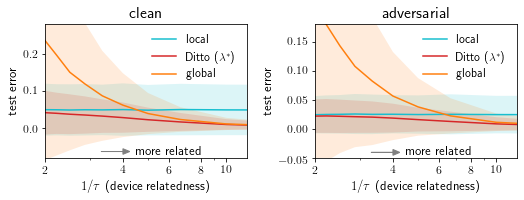

In [33]:
f = plt.figure(figsize=[7.5, 3])

ax = plt.subplot(1, 2, 1)
plt.title("clean")
print(var_[0])
errorfill(1.0 / taus, np.array(mse[0]), 
          np.array([np.sqrt(a) for a in var_[0]]), label='local', color='#17becf')
errorfill(1.0/taus, np.array(mse[1]), 
          np.array([np.sqrt(a) for a in var_[1]]), label=r"Ditto ($\lambda^*$)", color='#d62728')
errorfill(1.0/taus, np.array(mse[2]), 
          np.array([np.sqrt(a) for a in var_[2]]), label='global', color='#ff7f0e')

plt.ylabel('test error')
plt.xlabel(r'$1/\tau$ (device relatedness)')
plt.xscale('log')


plt.legend(frameon=False, fontsize=12)
plt.ylim(-0.08, 0.28)
plt.xlim(2, 12)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
plt.xticks(np.array([2, 4, 6, 8, 10]))


ax.arrow(3.3, -0.062, 0.7, 0, width=0.00013, head_width=0.015, head_length=0.25, fc='gray', ec='gray')
ax.annotate('more related', (4.5, -0.07), fontsize=13)

ax = plt.subplot(1, 2, 2)
plt.title("adversarial")
errorfill(1.0 / taus, np.array(mse2[0]), 
          np.array([np.sqrt(a) for a in var_2[0]]), label='local', color='#17becf')
errorfill(1.0 / taus, np.array(mse2[1]), 
          np.array([np.sqrt(a) for a in var_2[1]]), label=r"Ditto ($\lambda^*$)", color='#d62728')
errorfill(1.0 / taus, np.array(mse2[2]), 
          np.array([np.sqrt(a) for a in var_2[2]]), label='global', color='#ff7f0e')
plt.ylabel('test error')
plt.xlabel(r'$1 / \tau$ (device relatedness)')
plt.xscale('log')

plt.legend(frameon=False, fontsize=12)
plt.ylim(-0.05, 0.18)
plt.xlim(2, 12)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
plt.xticks(np.array([2, 4, 6, 8, 10]))
ax.arrow(3.3, -0.04, 0.7, 0, width=0.0001, head_width=0.01, head_length=0.25, fc='gray', ec='gray')
ax.annotate('more related', (4.5, -0.044), fontsize=13)


plt.tight_layout()
#f.savefig("pe_fig2.pdf")